In [1]:
import pandas as pd
from pathlib import Path
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVC

import matplotlib.pyplot as plt

# Import plotnine for ggplot2 like plotting
from plotnine import ggplot, aes, labs, theme, coord_flip
# Import plotnine geoms to plot
from plotnine import geom_point, geom_bar, geom_abline
# Formating
from plotnine import scale_x_discrete, scale_y_continuous
from mizani.formatters import percent_format

from scripts.model.model_classification import ModelDataGeneration, ModelGeneration

In [2]:
PATH_DATA = Path("data")

# Modelación del problema

Para el presente problema se escoge una división del problema en dos etapas debido al desbalanceo de los datos para la predicción directa de un porcentaje de descuento:
1. **Modelo de clasificación de items para definir si aplica descuento (Variable objetivo: has_discount)**: Este modelo busca determinar si es adecuado o no ofrecer o no un descuento a un producto dado según sus características
2. **Modelo de predicción de tasa de descuento (Variable objetivo: discount_rate)**: Este modelo definira el porcentaje de descuento sugerido para un producto, teniendo unicamente en cuenta la data de los items que poseen un descuento.

In [3]:
model_data = pd.read_csv(PATH_DATA / 'preprocessed_model_data.csv')
model_data.head()

,price,available_quantity,accepts_mercadopago,catalog_listing,shipping_free_shipping,installments_quantity,transactions_total,discount_rate,has_discount,expiration_days,...,level_id_5_green,power_seller_status_gold,power_seller_status_platinum,power_seller_status_silver,user_type_branch,user_type_brand,user_type_car_dealer,user_type_franchise,user_type_normal,user_type_real_estate_agency
0,23309.0,1,1,1,0,36.0,5829,0.00000,0,6956,...,1,0,1,0,0,1,0,0,0,0
1,37427.0,1,1,1,0,36.0,5829,0.00000,0,7284,...,1,0,1,0,0,1,0,0,0,0
2,19159.0,250,1,1,0,1.0,2343,0.00000,0,6822,...,1,0,0,0,0,0,0,0,1,0
3,1629900.0,150,1,1,1,12.0,22299,0.09445,1,7037,...,1,0,1,0,0,1,0,0,0,0
4,605000.0,1,1,1,1,36.0,812,0.00000,0,6639,...,1,1,0,0,0,0,0,0,1,0


In [4]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114651 entries, 0 to 114650
Data columns (total 75 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   price                                 114651 non-null  float64
 1   available_quantity                    114651 non-null  int64  
 2   accepts_mercadopago                   114651 non-null  int64  
 3   catalog_listing                       114651 non-null  int64  
 4   shipping_free_shipping                114651 non-null  int64  
 5   installments_quantity                 114651 non-null  float64
 6   transactions_total                    114651 non-null  int64  
 7   discount_rate                         114651 non-null  float64
 8   has_discount                          114651 non-null  int64  
 9   expiration_days                       114651 non-null  int64  
 10  condition_new                         114651 non-null  int64  
 11  

## 1 Modelo de clasificación de items para definir si aplica descuento

### 1.1 División de features

Usaremos *has_discount* como variable objetivo y todas las demás como las utilizaremos como features para la predicción, a excepción de la variable *discount_rate*. Esto debido a que *has_discount* surge de la variable *discount_rate*, con lo cuál le estaríamos brindando erroneamente al modelo una pista respecto a sus variables predictoras.

In [5]:
X = model_data.drop(['has_discount', "discount_rate"], axis=1)
y = model_data["has_discount"]

### 1.2 Balanceo de clases

Vemos que existe un desbalanceo elevado en las clases de *has_discount*

In [6]:
model_data["has_discount"].value_counts(normalize=True)

has_discount
0    0.782488
1    0.217512
Name: proportion, dtype: float64

Para solucionar esta situación se opta por realizar un undersampling sobre el dataset para igual las clases

In [7]:
x_under, y_under = ModelDataGeneration.under_sample_data(X, y)

In [8]:
print(y_under.shape)
y_under.value_counts(normalize=True)

(49876,)


has_discount
0    0.5
1    0.5
Name: proportion, dtype: float64

### 1.3 División de datos train-test

In [9]:
X_train, X_test, X_val, y_val,y_train, y_test = ModelDataGeneration.split_data(x_under, y_under)

### 1.4 Generación del modelo XGBoost Classifier

In [10]:
class_model_xgb = XGBClassifier()
xgb_model = ModelGeneration(class_model_xgb, (X_train, X_test, X_val, y_val,y_train, y_test))
xgb_model.model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
xgb_model.fit_model()

Using XGBoost


c:\Users\heile\anaconda3\envs\ml_discounts\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-auc:0.71913	validation_1-auc:0.72537
[1]	validation_0-auc:0.74462	validation_1-auc:0.75082
[2]	validation_0-auc:0.75526	validation_1-auc:0.75871
[3]	validation_0-auc:0.76389	validation_1-auc:0.76775
[4]	validation_0-auc:0.77164	validation_1-auc:0.77455
[5]	validation_0-auc:0.78323	validation_1-auc:0.78697
[6]	validation_0-auc:0.79014	validation_1-auc:0.79215
[7]	validation_0-auc:0.79656	validation_1-auc:0.79782
[8]	validation_0-auc:0.79880	validation_1-auc:0.79859
[9]	validation_0-auc:0.80595	validation_1-auc:0.80591
[10]	validation_0-auc:0.80874	validation_1-auc:0.80771
[11]	validation_0-auc:0.80992	validation_1-auc:0.80872
[12]	validation_0-auc:0.81353	validation_1-auc:0.81105
[13]	validation_0-auc:0.81753	validation_1-auc:0.81539
[14]	validation_0-auc:0.81971	validation_1-auc:0.81637
[15]	validation_0-auc:0.82094	validation_1-auc:0.81625
[16]	validation_0-auc:0.82360	validation_1-auc:0.81690
[17]	validation_0-auc:0.82660	validation_1-auc:0.81839
[18]	validation_0-au

[22]	validation_0-auc:0.83863	validation_1-auc:0.82674
[23]	validation_0-auc:0.84108	validation_1-auc:0.82754
[24]	validation_0-auc:0.84207	validation_1-auc:0.82824
[25]	validation_0-auc:0.84768	validation_1-auc:0.83240
[26]	validation_0-auc:0.84858	validation_1-auc:0.83277
[27]	validation_0-auc:0.84998	validation_1-auc:0.83346
[28]	validation_0-auc:0.85307	validation_1-auc:0.83505
[29]	validation_0-auc:0.85398	validation_1-auc:0.83541
[30]	validation_0-auc:0.85705	validation_1-auc:0.83806
[31]	validation_0-auc:0.86041	validation_1-auc:0.84082
[32]	validation_0-auc:0.86332	validation_1-auc:0.84374
[33]	validation_0-auc:0.86566	validation_1-auc:0.84470
[34]	validation_0-auc:0.86733	validation_1-auc:0.84568
[35]	validation_0-auc:0.86734	validation_1-auc:0.84570
[36]	validation_0-auc:0.87114	validation_1-auc:0.84932
[37]	validation_0-auc:0.87165	validation_1-auc:0.84917
[38]	validation_0-auc:0.87218	validation_1-auc:0.84935
[39]	validation_0-auc:0.87353	validation_1-auc:0.85072
[40]	valid

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### 1.4.1 Métricas iniciales

In [12]:
xgb_model.test_model()

El AUC score es de 0.7903143755285142
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      3686
           1       0.78      0.82      0.80      3796

    accuracy                           0.79      7482
   macro avg       0.79      0.79      0.79      7482
weighted avg       0.79      0.79      0.79      7482



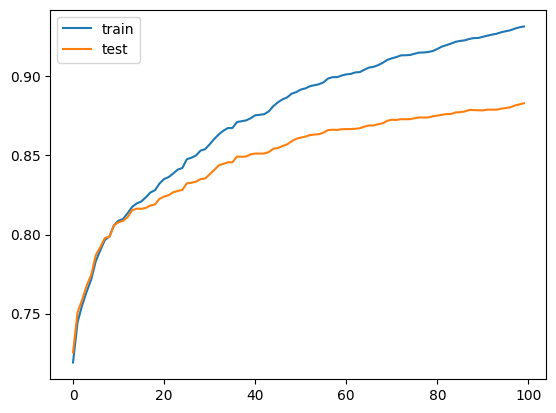

In [13]:
results = xgb_model.model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['auc'], label='train')
plt.plot(results['validation_1']['auc'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

#### 1.4.2 Feature importance

In [14]:
feature_imp = xgb_model.feature_importance_xgb()
feature_imp.shape

(57, 3)

In [15]:
feature_imp.head(10)

,feature,importance,relative_importance
7,condition_new,183.942703,0.197698
50,level_id_5_green,168.684235,0.181299
14,shipping_logistic_type_fulfillment,46.371109,0.049839
25,category_MCO118204,44.276688,0.047588
43,category_MCO3025,37.156258,0.039935
23,category_MCO1168,27.415333,0.029465
54,user_type_brand,26.619986,0.028611
42,category_MCO1953,20.517067,0.022051
44,category_MCO3937,18.011690,0.019359
24,category_MCO1182,15.678099,0.016851


Vemos que de manera general, variables como *condition_new*, *level_id*, *shipping_logistic_type*, *category* y *user_type* son las variables que explican principalmente el modelo.

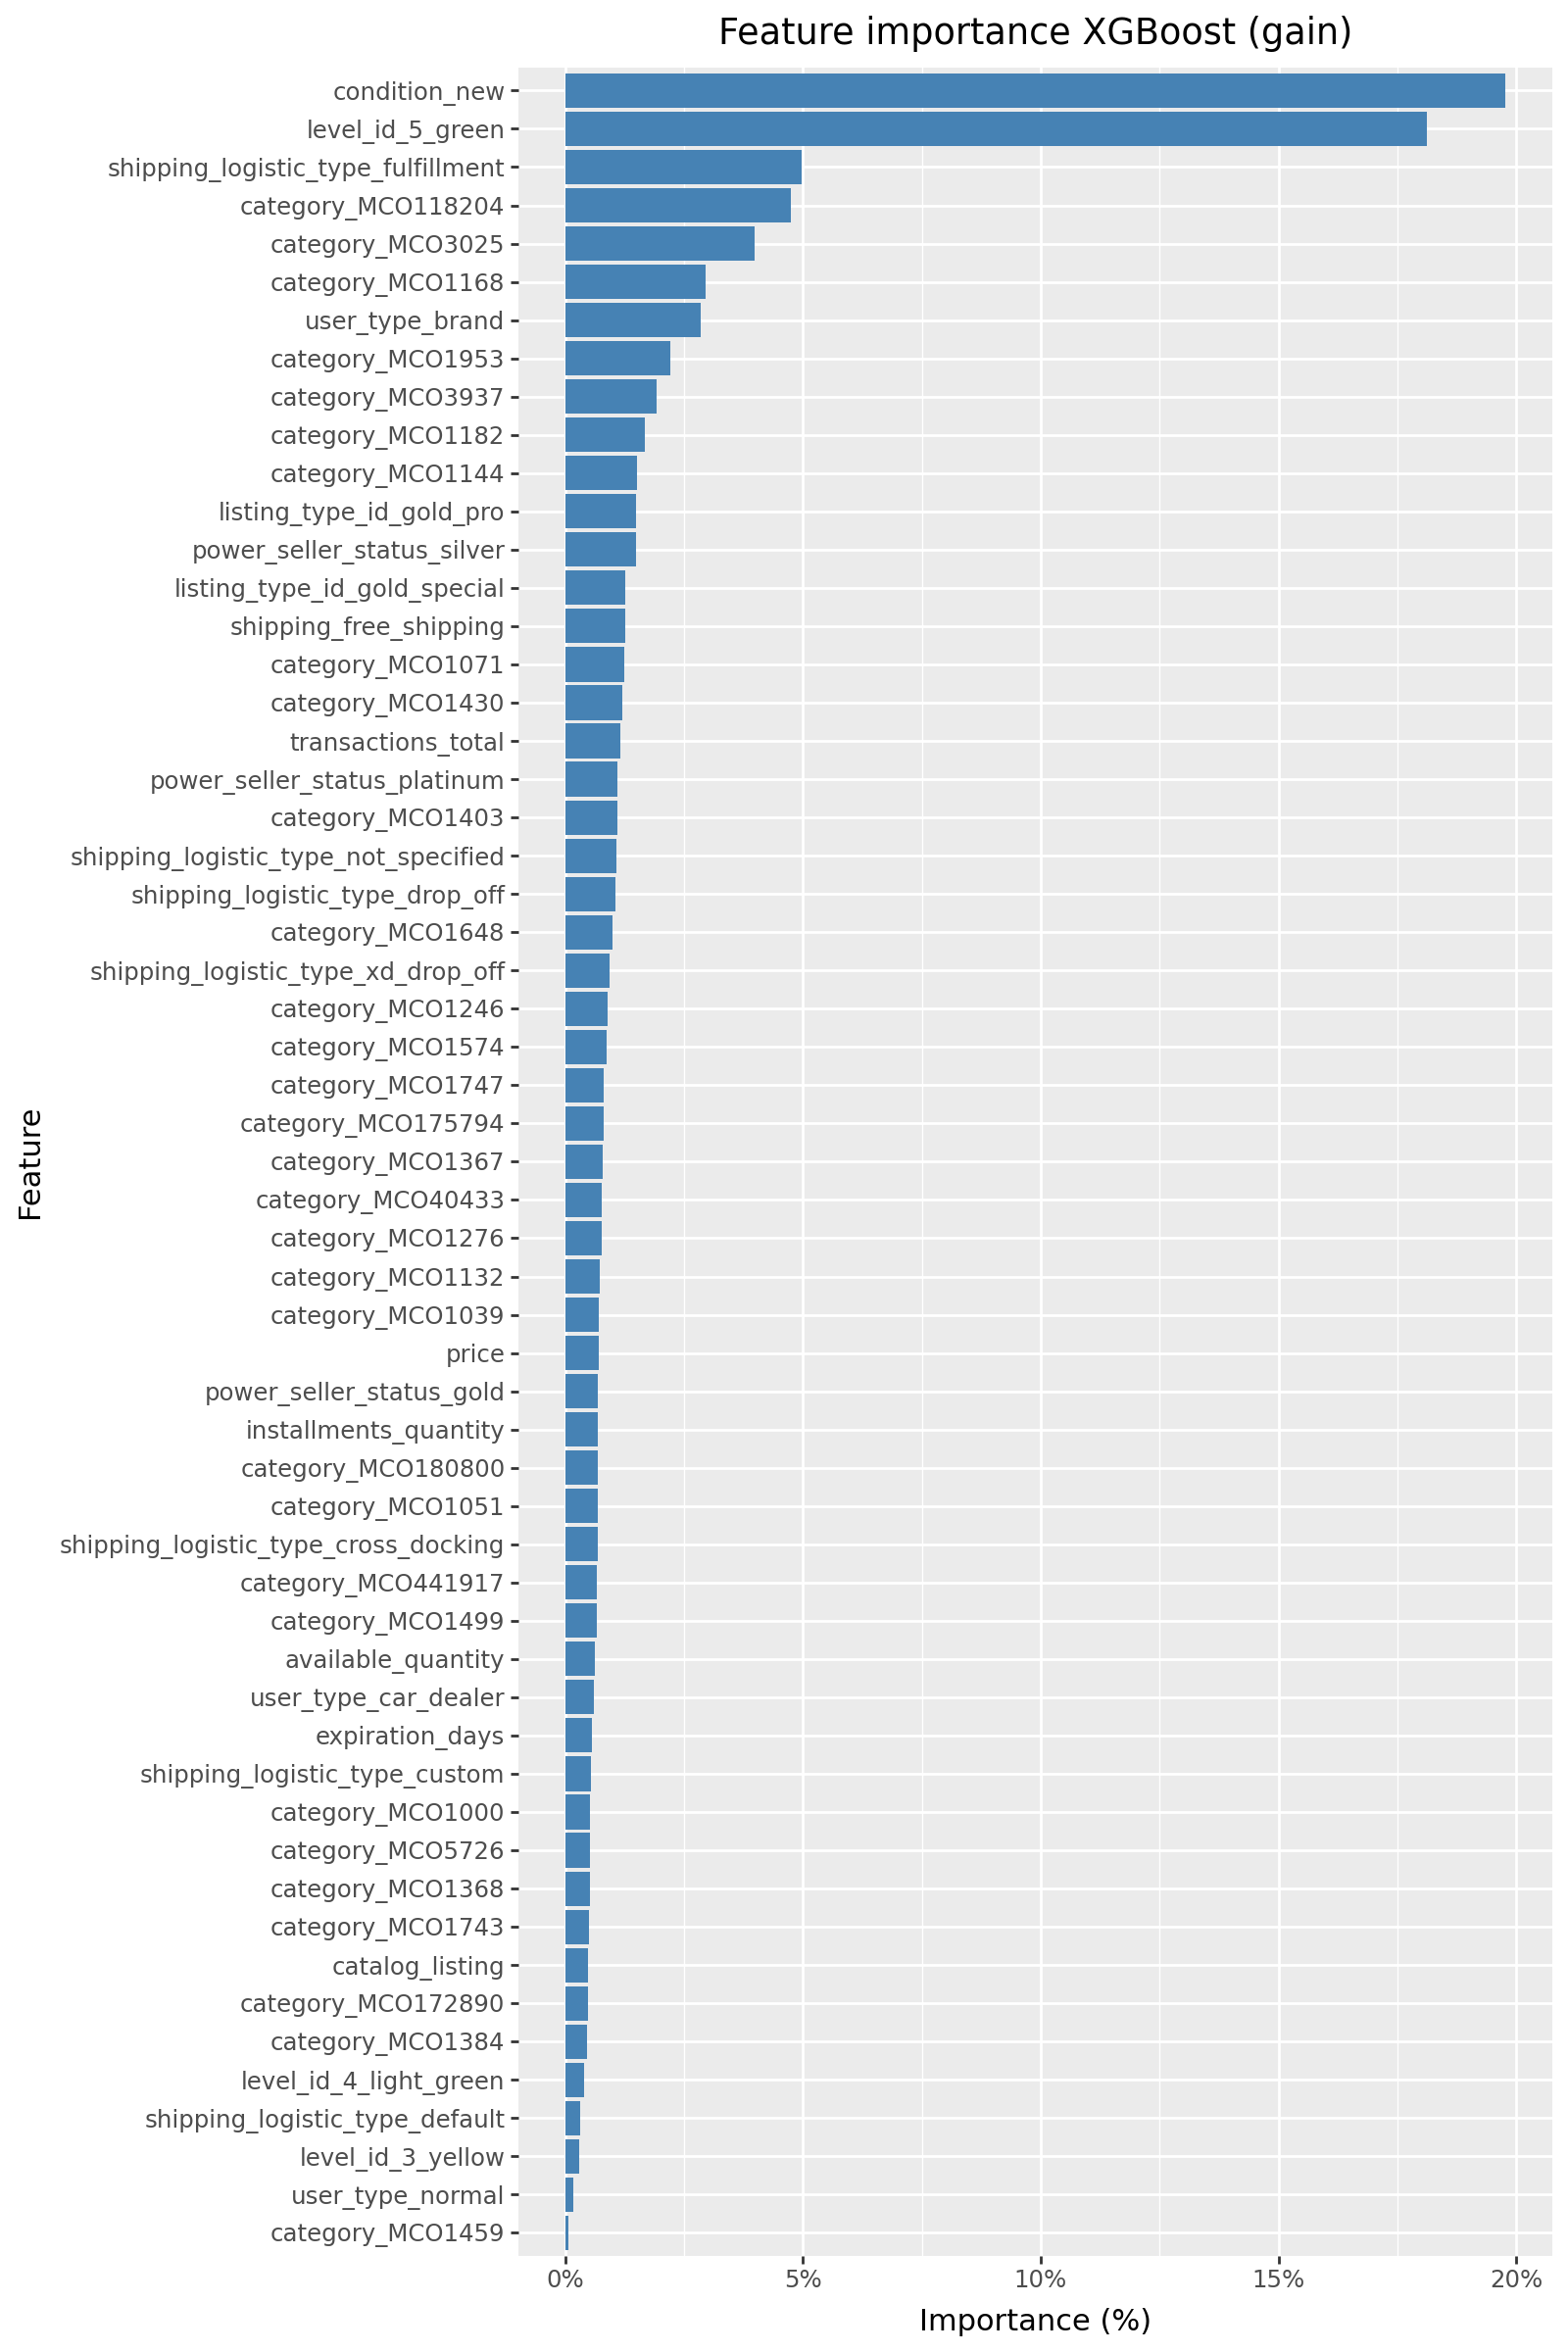

In [16]:
feature_order = feature_imp["feature"].tolist()

(ggplot(feature_imp, aes(x='feature', y='relative_importance')) +
 geom_bar(stat='identity', fill='steelblue') +
 theme(legend_position="none", figure_size=(8, 12)) + 
 labs(title="Feature importance XGBoost (gain)", x="Feature", y="Importance (%)") + 
 scale_y_continuous(labels = percent_format()) +
 scale_x_discrete(limits = feature_order[::-1]) +
 coord_flip()
)

### 1.5 Generación del modelo support vector machines (SVM)

In [17]:
class_model_svm = SVC()
svm_model = ModelGeneration(class_model_svm, (X_train, X_test, X_val, y_val,y_train, y_test))
svm_model.fit_model()
svm_model.model

SVC()

#### 1.5.1 Métricas iniciales

In [18]:
svm_model.test_model()

El AUC score es de 0.5371873154309845
              precision    recall  f1-score   support

           0       0.98      0.08      0.14      3686
           1       0.53      1.00      0.69      3796

    accuracy                           0.54      7482
   macro avg       0.75      0.54      0.42      7482
weighted avg       0.75      0.54      0.42      7482



### 1.6 Optimización modelo XGBoost

#### 1.6.1 Grid search

In [19]:
param_grid = {
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.3, 0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7]
}


In [20]:
xgb_model.fit_grid_search(param_grid)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [21]:
print("Mejores hiperparametros: ", xgb_model.best_params_)
print("Mejor score: ", xgb_model.best_score_)

Mejores hiperparametros:  {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 8, 'subsample': 1}
Mejor score:  0.8846426751976022


In [22]:
xgb_model_tuned = ModelGeneration(XGBClassifier(), (X_train, X_test, X_val, y_val,y_train, y_test))
xgb_model_tuned.fit_model( xgb_model.best_params_)

Using XGBoost


c:\Users\heile\anaconda3\envs\ml_discounts\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-auc:0.74687	validation_1-auc:0.74839
[1]	validation_0-auc:0.77205	validation_1-auc:0.77537
[2]	validation_0-auc:0.79033	validation_1-auc:0.78998
[3]	validation_0-auc:0.79871	validation_1-auc:0.79696
[4]	validation_0-auc:0.80490	validation_1-auc:0.80065
[5]	validation_0-auc:0.81022	validation_1-auc:0.80185
[6]	validation_0-auc:0.81874	validation_1-auc:0.80739
[7]	validation_0-auc:0.82456	validation_1-auc:0.81235
[8]	validation_0-auc:0.83455	validation_1-auc:0.82254
[9]	validation_0-auc:0.83772	validation_1-auc:0.82581
[10]	validation_0-auc:0.84040	validation_1-auc:0.82747
[11]	validation_0-auc:0.84362	validation_1-auc:0.82783
[12]	validation_0-auc:0.84571	validation_1-auc:0.82785
[13]	validation_0-auc:0.84722	validation_1-auc:0.82831
[14]	validation_0-auc:0.85069	validation_1-auc:0.83026
[15]	validation_0-auc:0.85380	validation_1-auc:0.83080
[16]	validation_0-auc:0.85444	validation_1-auc:0.83116
[17]	validation_0-auc:0.85583	validation_1-auc:0.83111
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

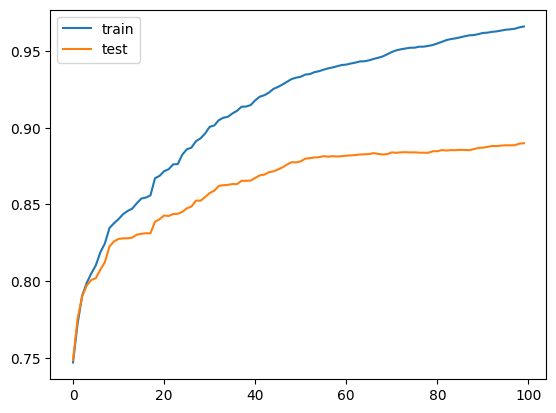

In [23]:
results = xgb_model_tuned.model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['auc'], label='train')
plt.plot(results['validation_1']['auc'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

In [24]:
xgb_model_tuned.test_model()

El AUC score es de 0.8054107273441444
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      3686
           1       0.79      0.83      0.81      3796

    accuracy                           0.81      7482
   macro avg       0.81      0.81      0.81      7482
weighted avg       0.81      0.81      0.81      7482



In [25]:
feature_imp_best = xgb_model_tuned.feature_importance_xgb()

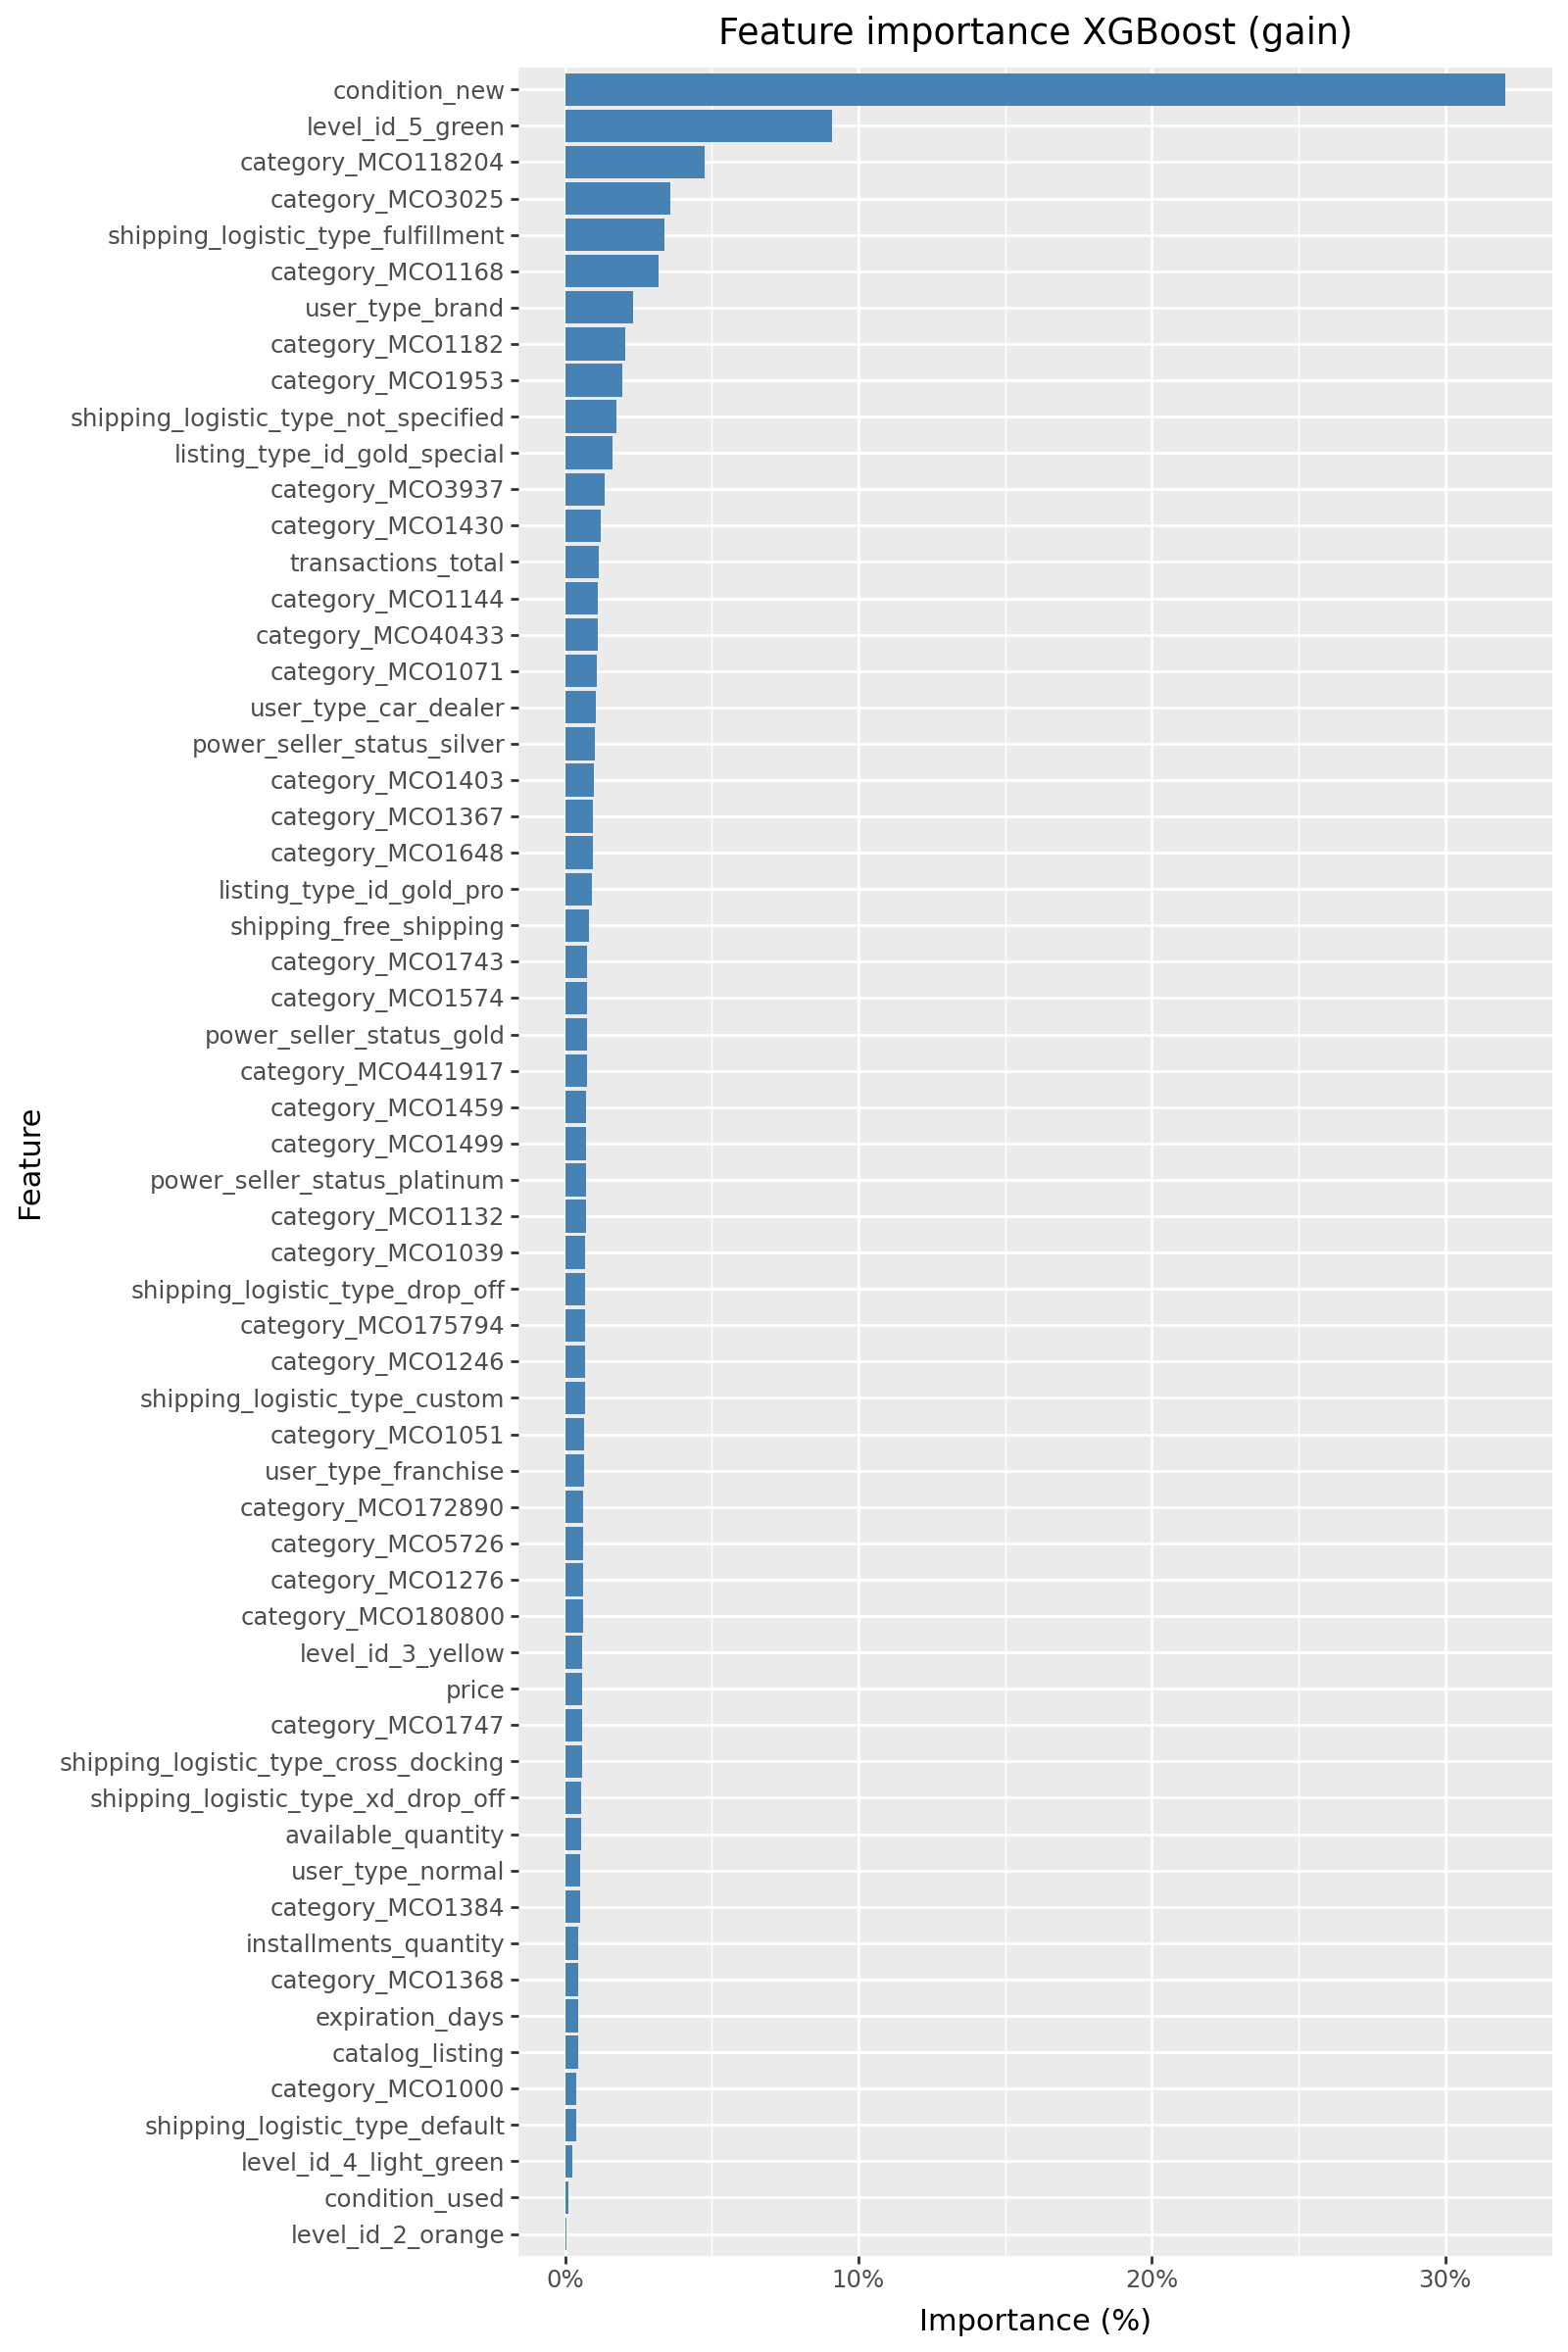

In [26]:
feature_order = feature_imp_best["feature"].tolist()

(ggplot(feature_imp_best, aes(x='feature', y='relative_importance')) +
 geom_bar(stat='identity', fill='steelblue') +
 theme(legend_position="none", figure_size=(8, 12)) + 
 labs(title="Feature importance XGBoost (gain)", x="Feature", y="Importance (%)") + 
 scale_y_continuous(labels = percent_format()) +
 scale_x_discrete(limits = feature_order[::-1]) +
 coord_flip()
)

#### 1.6.2 Remove less important features

In [27]:
updated_features = feature_imp_best[feature_imp_best['relative_importance'].cumsum() <= 0.95]
print("Cantidad de features originales:", feature_imp_best.shape[0])
print("Cantidad de features actualizadas:", updated_features.shape[0])


Cantidad de features originales: 60
Cantidad de features actualizadas: 47


In [28]:
cols_to_keep = updated_features["feature"].tolist()
model_xgb = XGBClassifier()
xgb_model_best = ModelGeneration(model_xgb, (X_train[cols_to_keep], X_test[cols_to_keep], X_val[cols_to_keep], y_val,y_train, y_test))
xgb_model_best.fit_model(xgb_model.best_params_)

Using XGBoost
[0]	validation_0-auc:0.76082	validation_1-auc:0.75742

c:\Users\heile\anaconda3\envs\ml_discounts\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[1]	validation_0-auc:0.78283	validation_1-auc:0.78116
[2]	validation_0-auc:0.78918	validation_1-auc:0.78915
[3]	validation_0-auc:0.79232	validation_1-auc:0.79167
[4]	validation_0-auc:0.80216	validation_1-auc:0.80138
[5]	validation_0-auc:0.81224	validation_1-auc:0.80950
[6]	validation_0-auc:0.81941	validation_1-auc:0.81634
[7]	validation_0-auc:0.82597	validation_1-auc:0.82016
[8]	validation_0-auc:0.83049	validation_1-auc:0.82387
[9]	validation_0-auc:0.83361	validation_1-auc:0.82647
[10]	validation_0-auc:0.83526	validation_1-auc:0.82783
[11]	validation_0-auc:0.83590	validation_1-auc:0.82791
[12]	validation_0-auc:0.84103	validation_1-auc:0.83281
[13]	validation_0-auc:0.84354	validation_1-auc:0.83388
[14]	validation_0-auc:0.84469	validation_1-auc:0.83414
[15]	validation_0-auc:0.84912	validation_1-auc:0.83711
[16]	validation_0-auc:0.85188	validation_1-auc:0.83821
[17]	validation_0-auc:0.85609	validation_1-auc:0.84089
[18]	validation_0-auc:0.85642	validation_1-auc:0.84099
[19]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
xgb_model_best.test_model()

El AUC score es de 0.8107659088842983
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      3686
           1       0.80      0.84      0.82      3796

    accuracy                           0.81      7482
   macro avg       0.81      0.81      0.81      7482
weighted avg       0.81      0.81      0.81      7482



In [30]:
feature_imp_best_final = xgb_model_best.feature_importance_xgb()

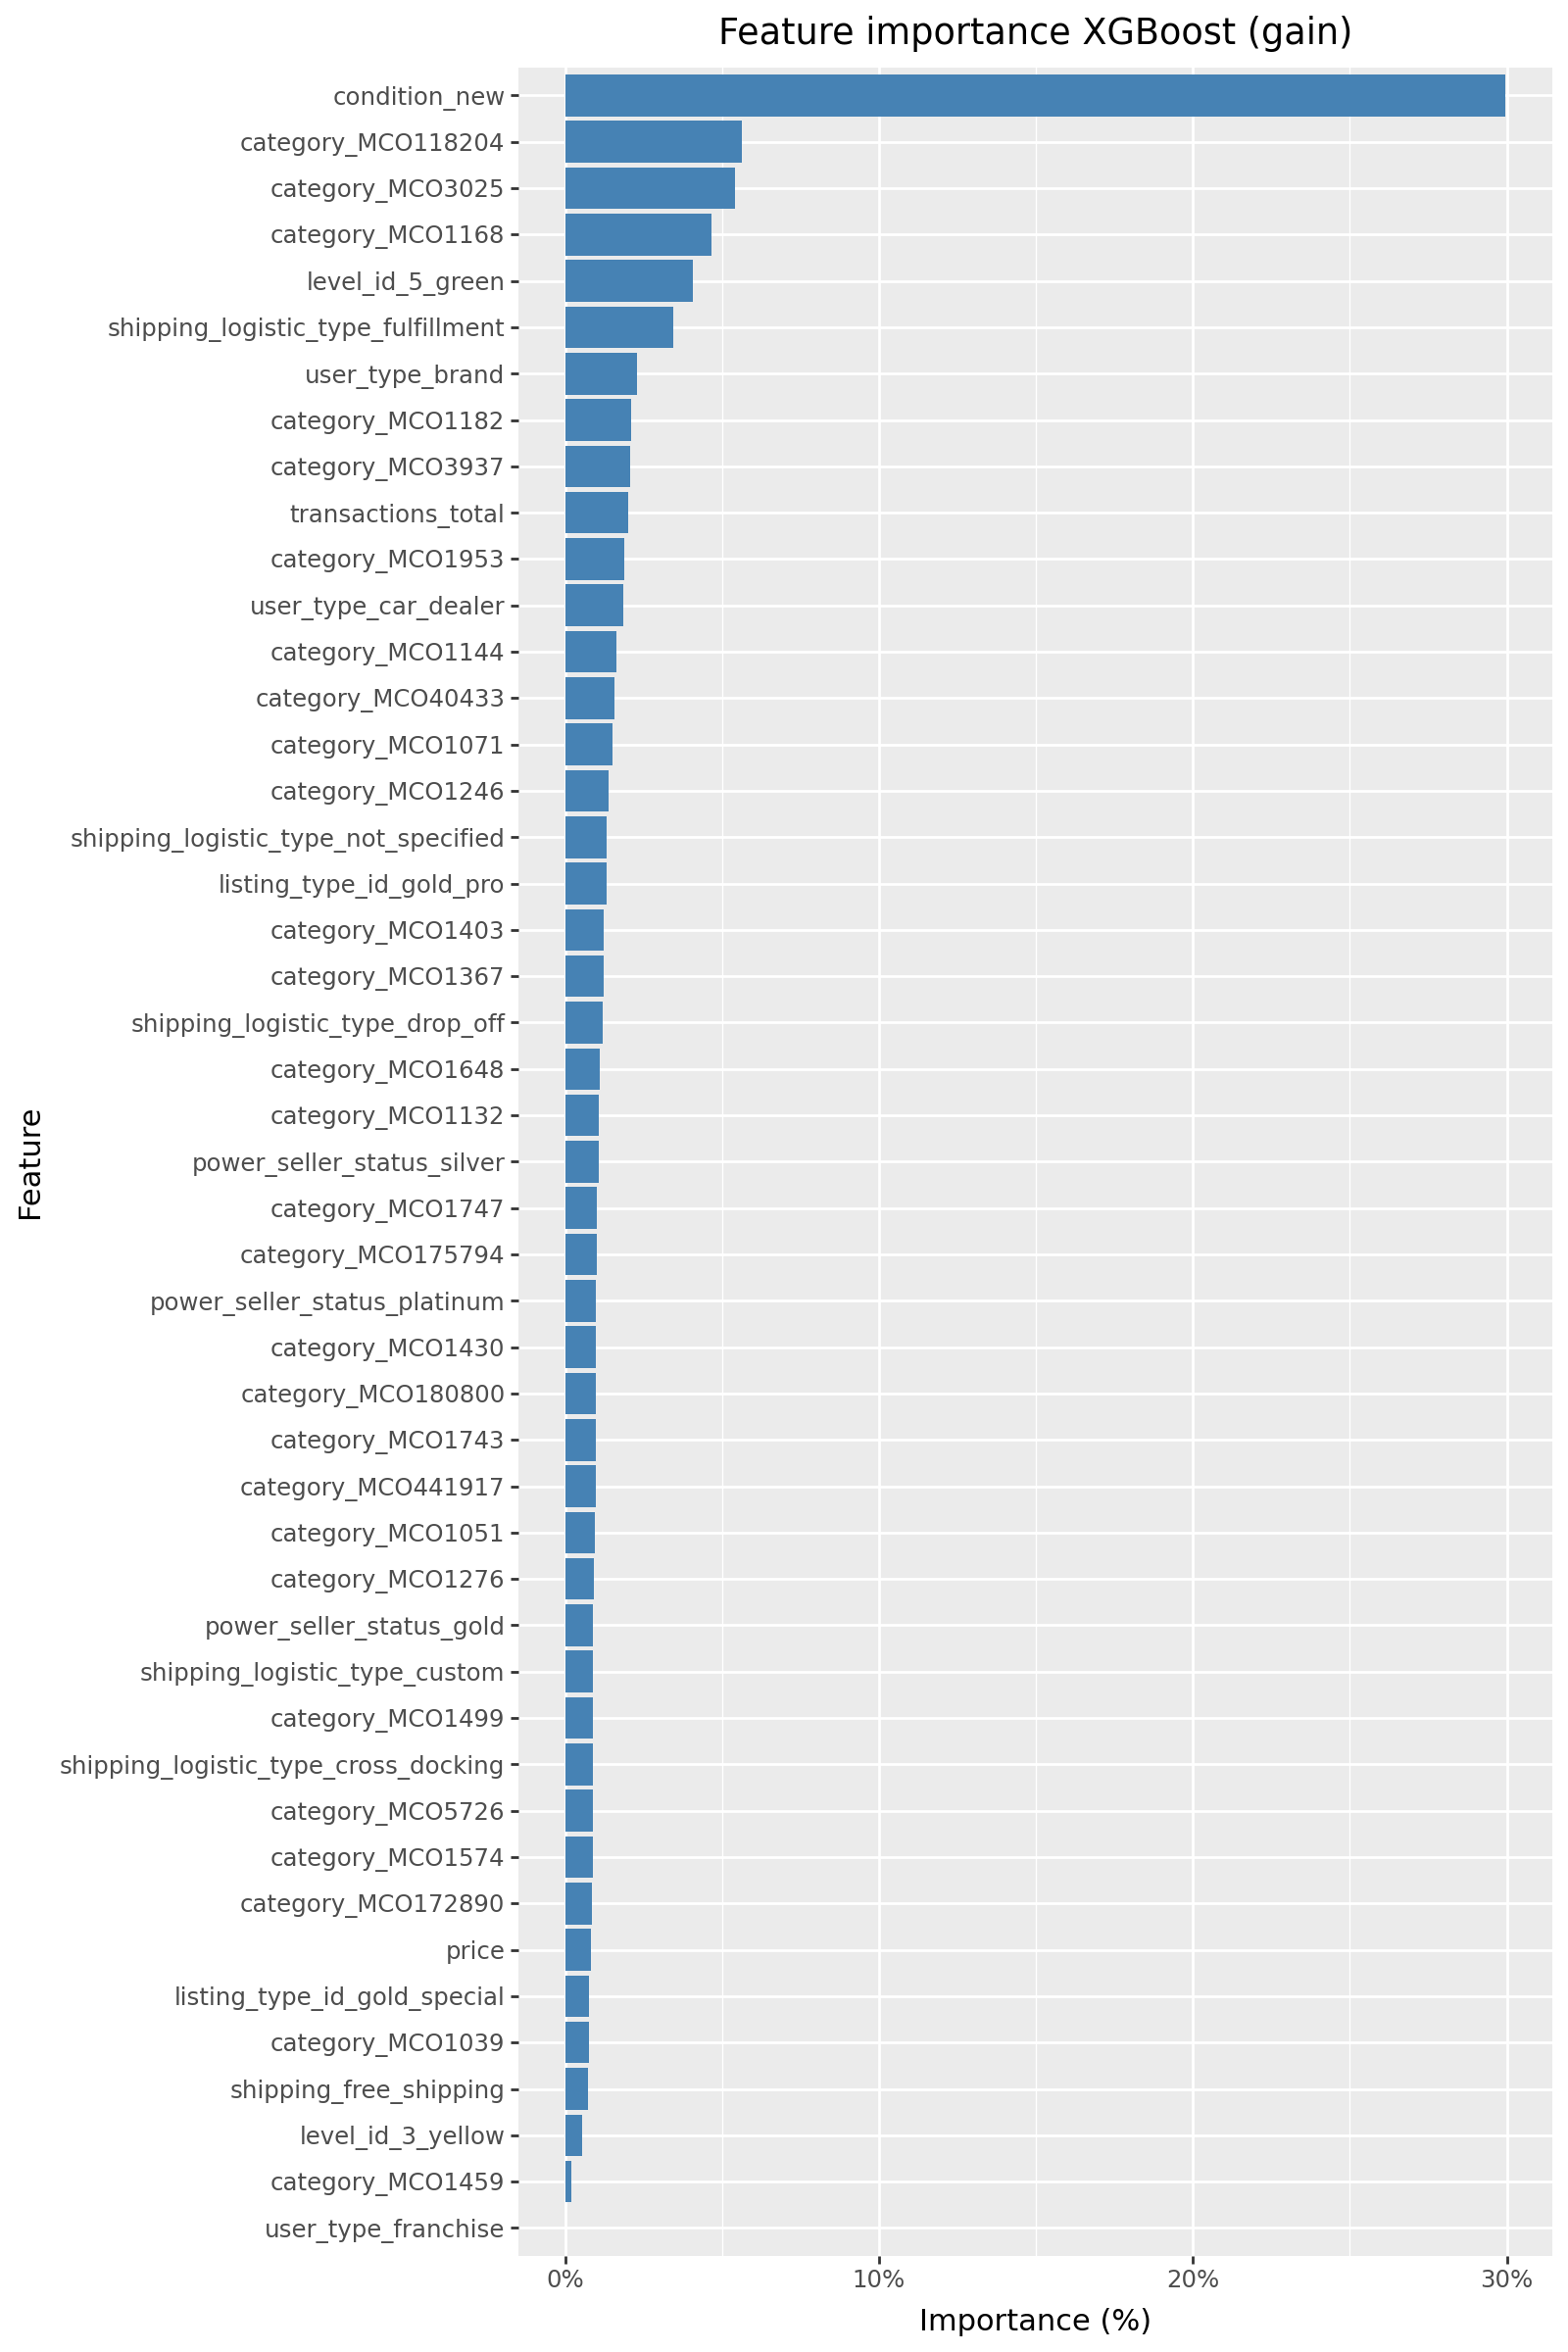

In [31]:
feature_order = feature_imp_best_final["feature"].tolist()

(ggplot(feature_imp_best_final, aes(x='feature', y='relative_importance')) +
 geom_bar(stat='identity', fill='steelblue') +
 theme(legend_position="none", figure_size=(8, 12)) + 
 labs(title="Feature importance XGBoost (gain)", x="Feature", y="Importance (%)") + 
 scale_y_continuous(labels = percent_format()) +
 scale_x_discrete(limits = feature_order[::-1]) +
 coord_flip()
)

c:\Users\heile\anaconda3\envs\ml_discounts\lib\site-packages\plotnine\layer.py:344: PlotnineWarning: position_stack : Removed 39 rows containing missing values.


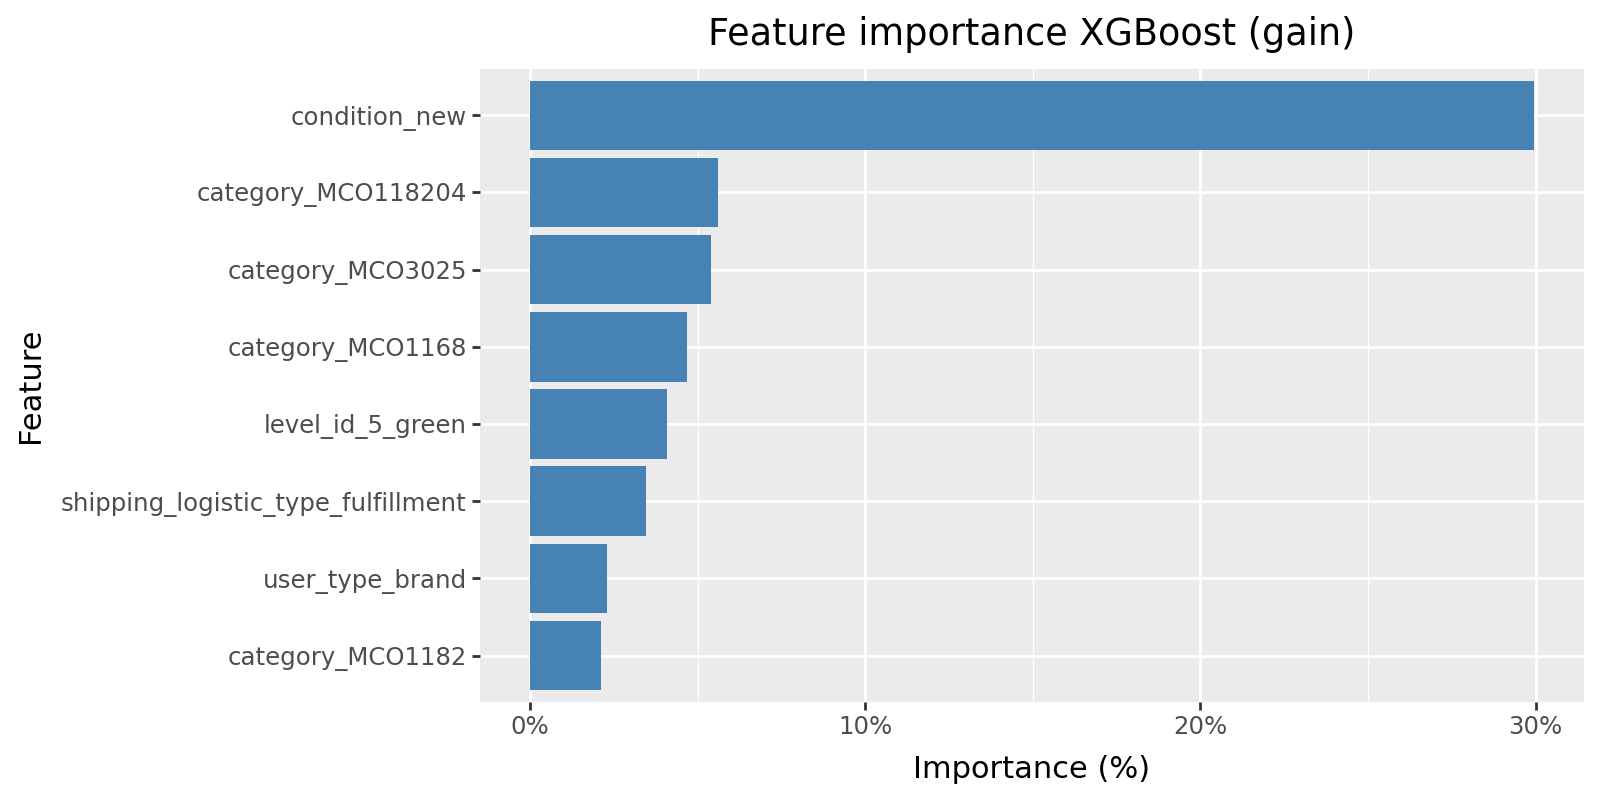

In [32]:
feature_order = feature_imp_best_final["feature"].head(8).tolist()

(ggplot(feature_imp_best_final, aes(x='feature', y='relative_importance')) +
 geom_bar(stat='identity', fill='steelblue') +
 theme(legend_position="none", figure_size=(8, 4)) + 
 labs(title="Feature importance XGBoost (gain)", x="Feature", y="Importance (%)") + 
 scale_y_continuous(labels = percent_format()) +
 scale_x_discrete(limits = feature_order[::-1]) +
 coord_flip()
)

In [33]:
xgb_model_best.model.save_model("classifier_discount_model.json")

## 2. Modelo de predicción de tasa de descuento

### 2.1 División de features

In [34]:
prediction_data = model_data[model_data.has_discount == 1].reset_index(drop = True)

print("Cantidad de datos:", prediction_data.shape[0])
X = prediction_data.drop(['has_discount', "discount_rate"], axis=1)
y = prediction_data["discount_rate"]

Cantidad de datos: 24938


### 2.2 División de datos train-test

In [35]:
X_train, X_test, X_val, y_val,y_train, y_test = ModelDataGeneration.split_data(X, y)

### 2.3 Generación del modelo XGBoost Regressor

In [36]:
reg_xgb = XGBRegressor()
reg_xgb = ModelGeneration(reg_xgb, (X_train, X_test, X_val, y_val,y_train, y_test))
reg_xgb.fit_model()
reg_xgb.model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### 2.3.1 Métricas iniciales

In [37]:
reg_xgb.test_model(type="regression")

El R2 score es de 0.5432136347951453
El RMSE es de 0.09038338280308832
El MAPE es de 0.5914425403578566


In [38]:
pred_results = pd.concat([y_test.reset_index(drop = True), 
                          pd.Series(reg_xgb.y_pred)], axis = 1).rename(columns = {"discount_rate" : "test",
                                                                                  0: "pred"})
pred_results.head()

,test,pred
0,0.140006,0.200570
1,0.270000,0.106389
2,0.087865,0.062850
3,0.150001,0.121270
4,0.455307,0.420338


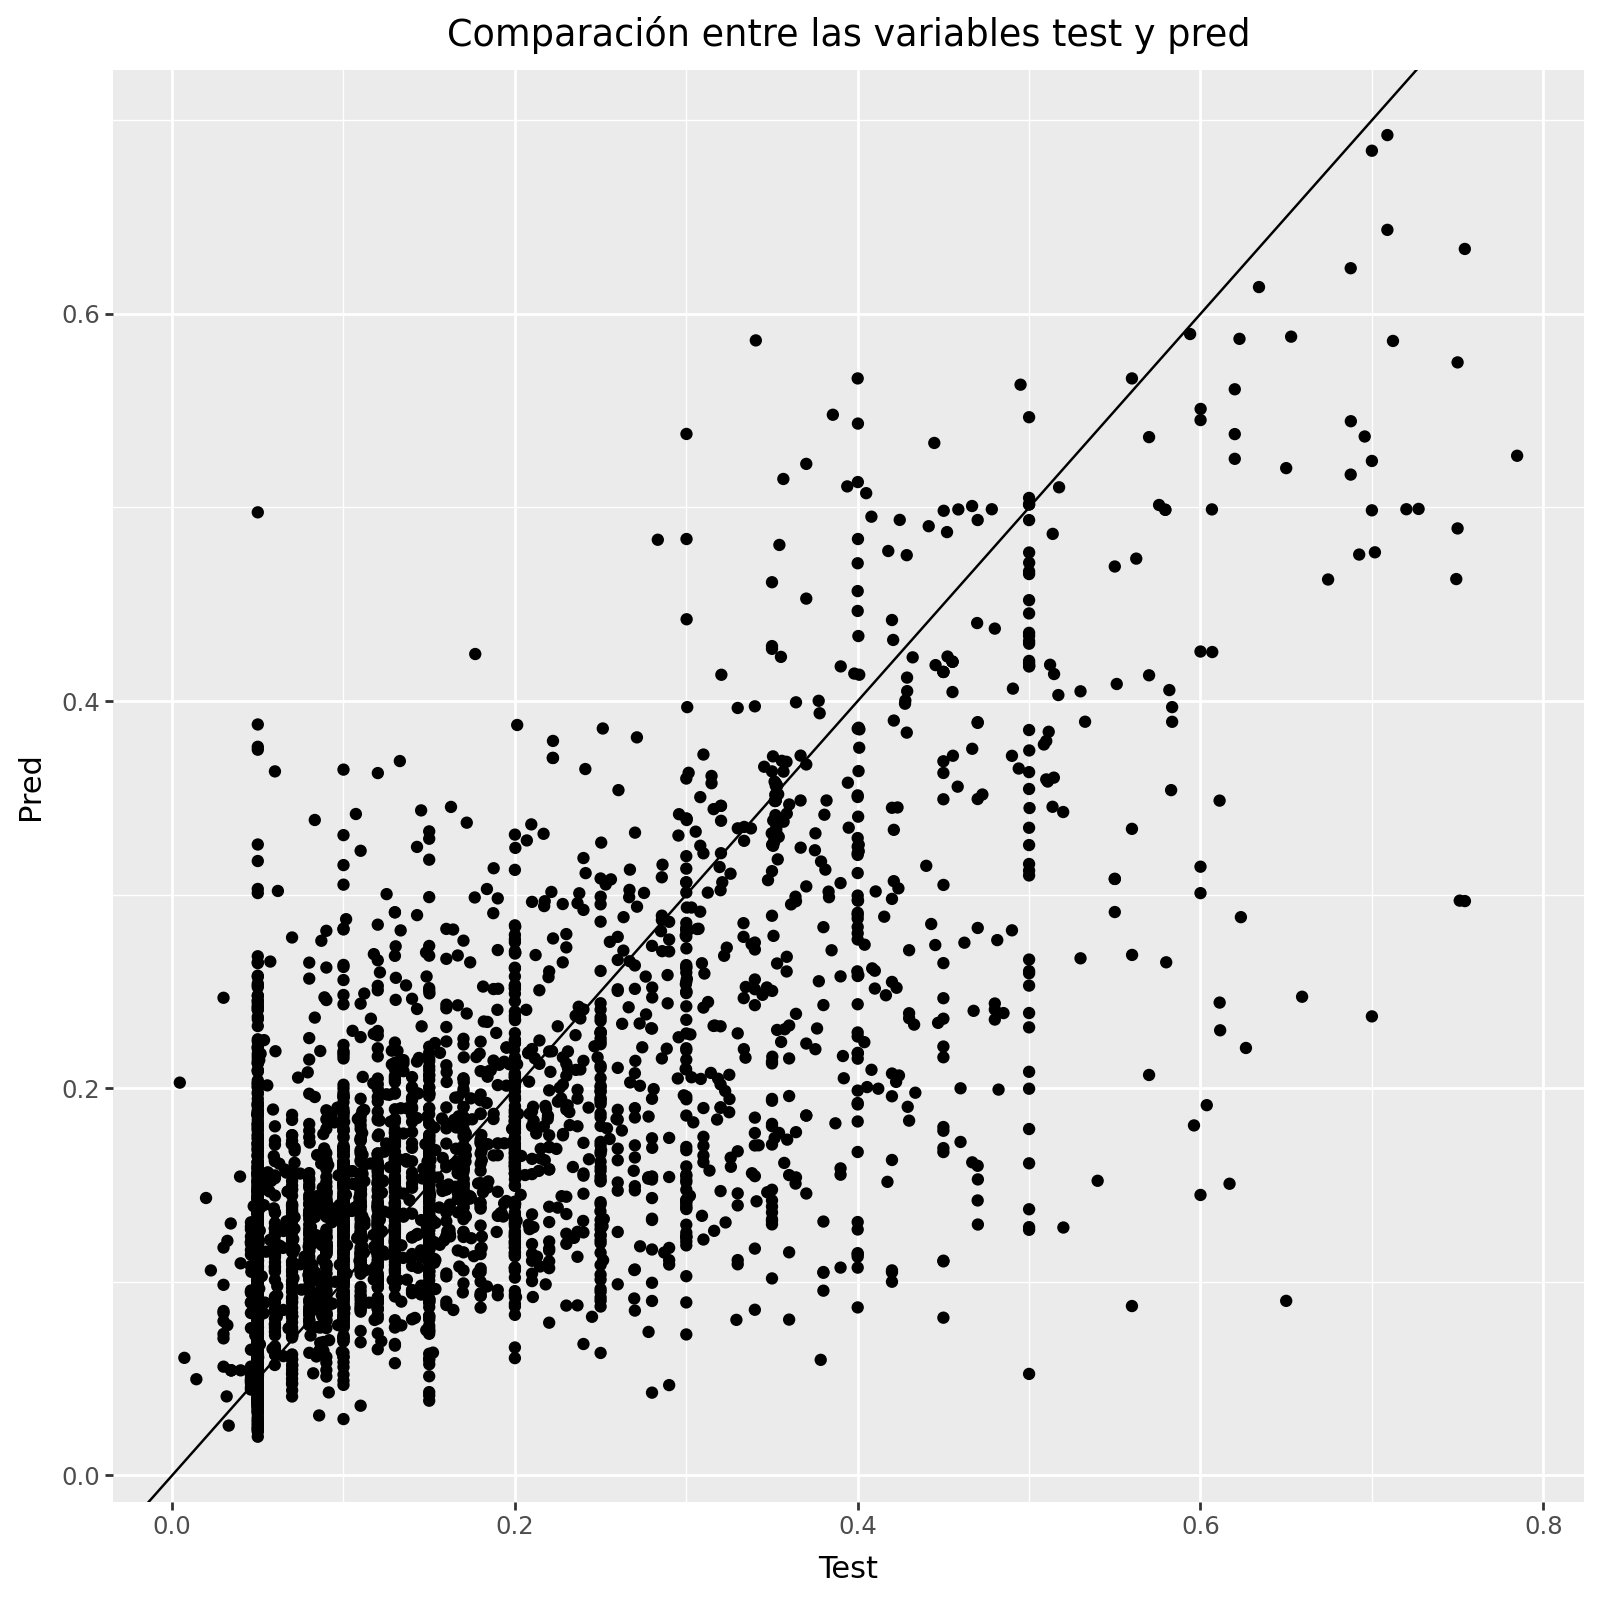

In [39]:
(ggplot(pred_results, aes(x='test', y='pred')) +
 geom_point() +
 geom_abline(
        intercept=0,  # set the y-intercept value
        slope=1,  # set the slope value
    ) +
 theme(figure_size=(8, 8)) + 
 labs(title="Comparación entre las variables test y pred", x="Test", y="Pred")
)

#### 2.3.2 Feature importance

In [40]:
feature_importance_scores_best = pd.DataFrame([reg_xgb.model.get_booster().get_score(importance_type='gain')]).T.reset_index()
feature_importance_scores_best.rename(columns={"index": "feature", 0: "importance"}, inplace=True)
feature_importance_scores_best = feature_importance_scores_best.sort_values(by = "importance", ascending = False)
feature_importance_scores_best["relative_importance"] = (feature_importance_scores_best['importance'] / feature_importance_scores_best['importance'].sum())
feature_importance_scores_best.shape

(54, 3)

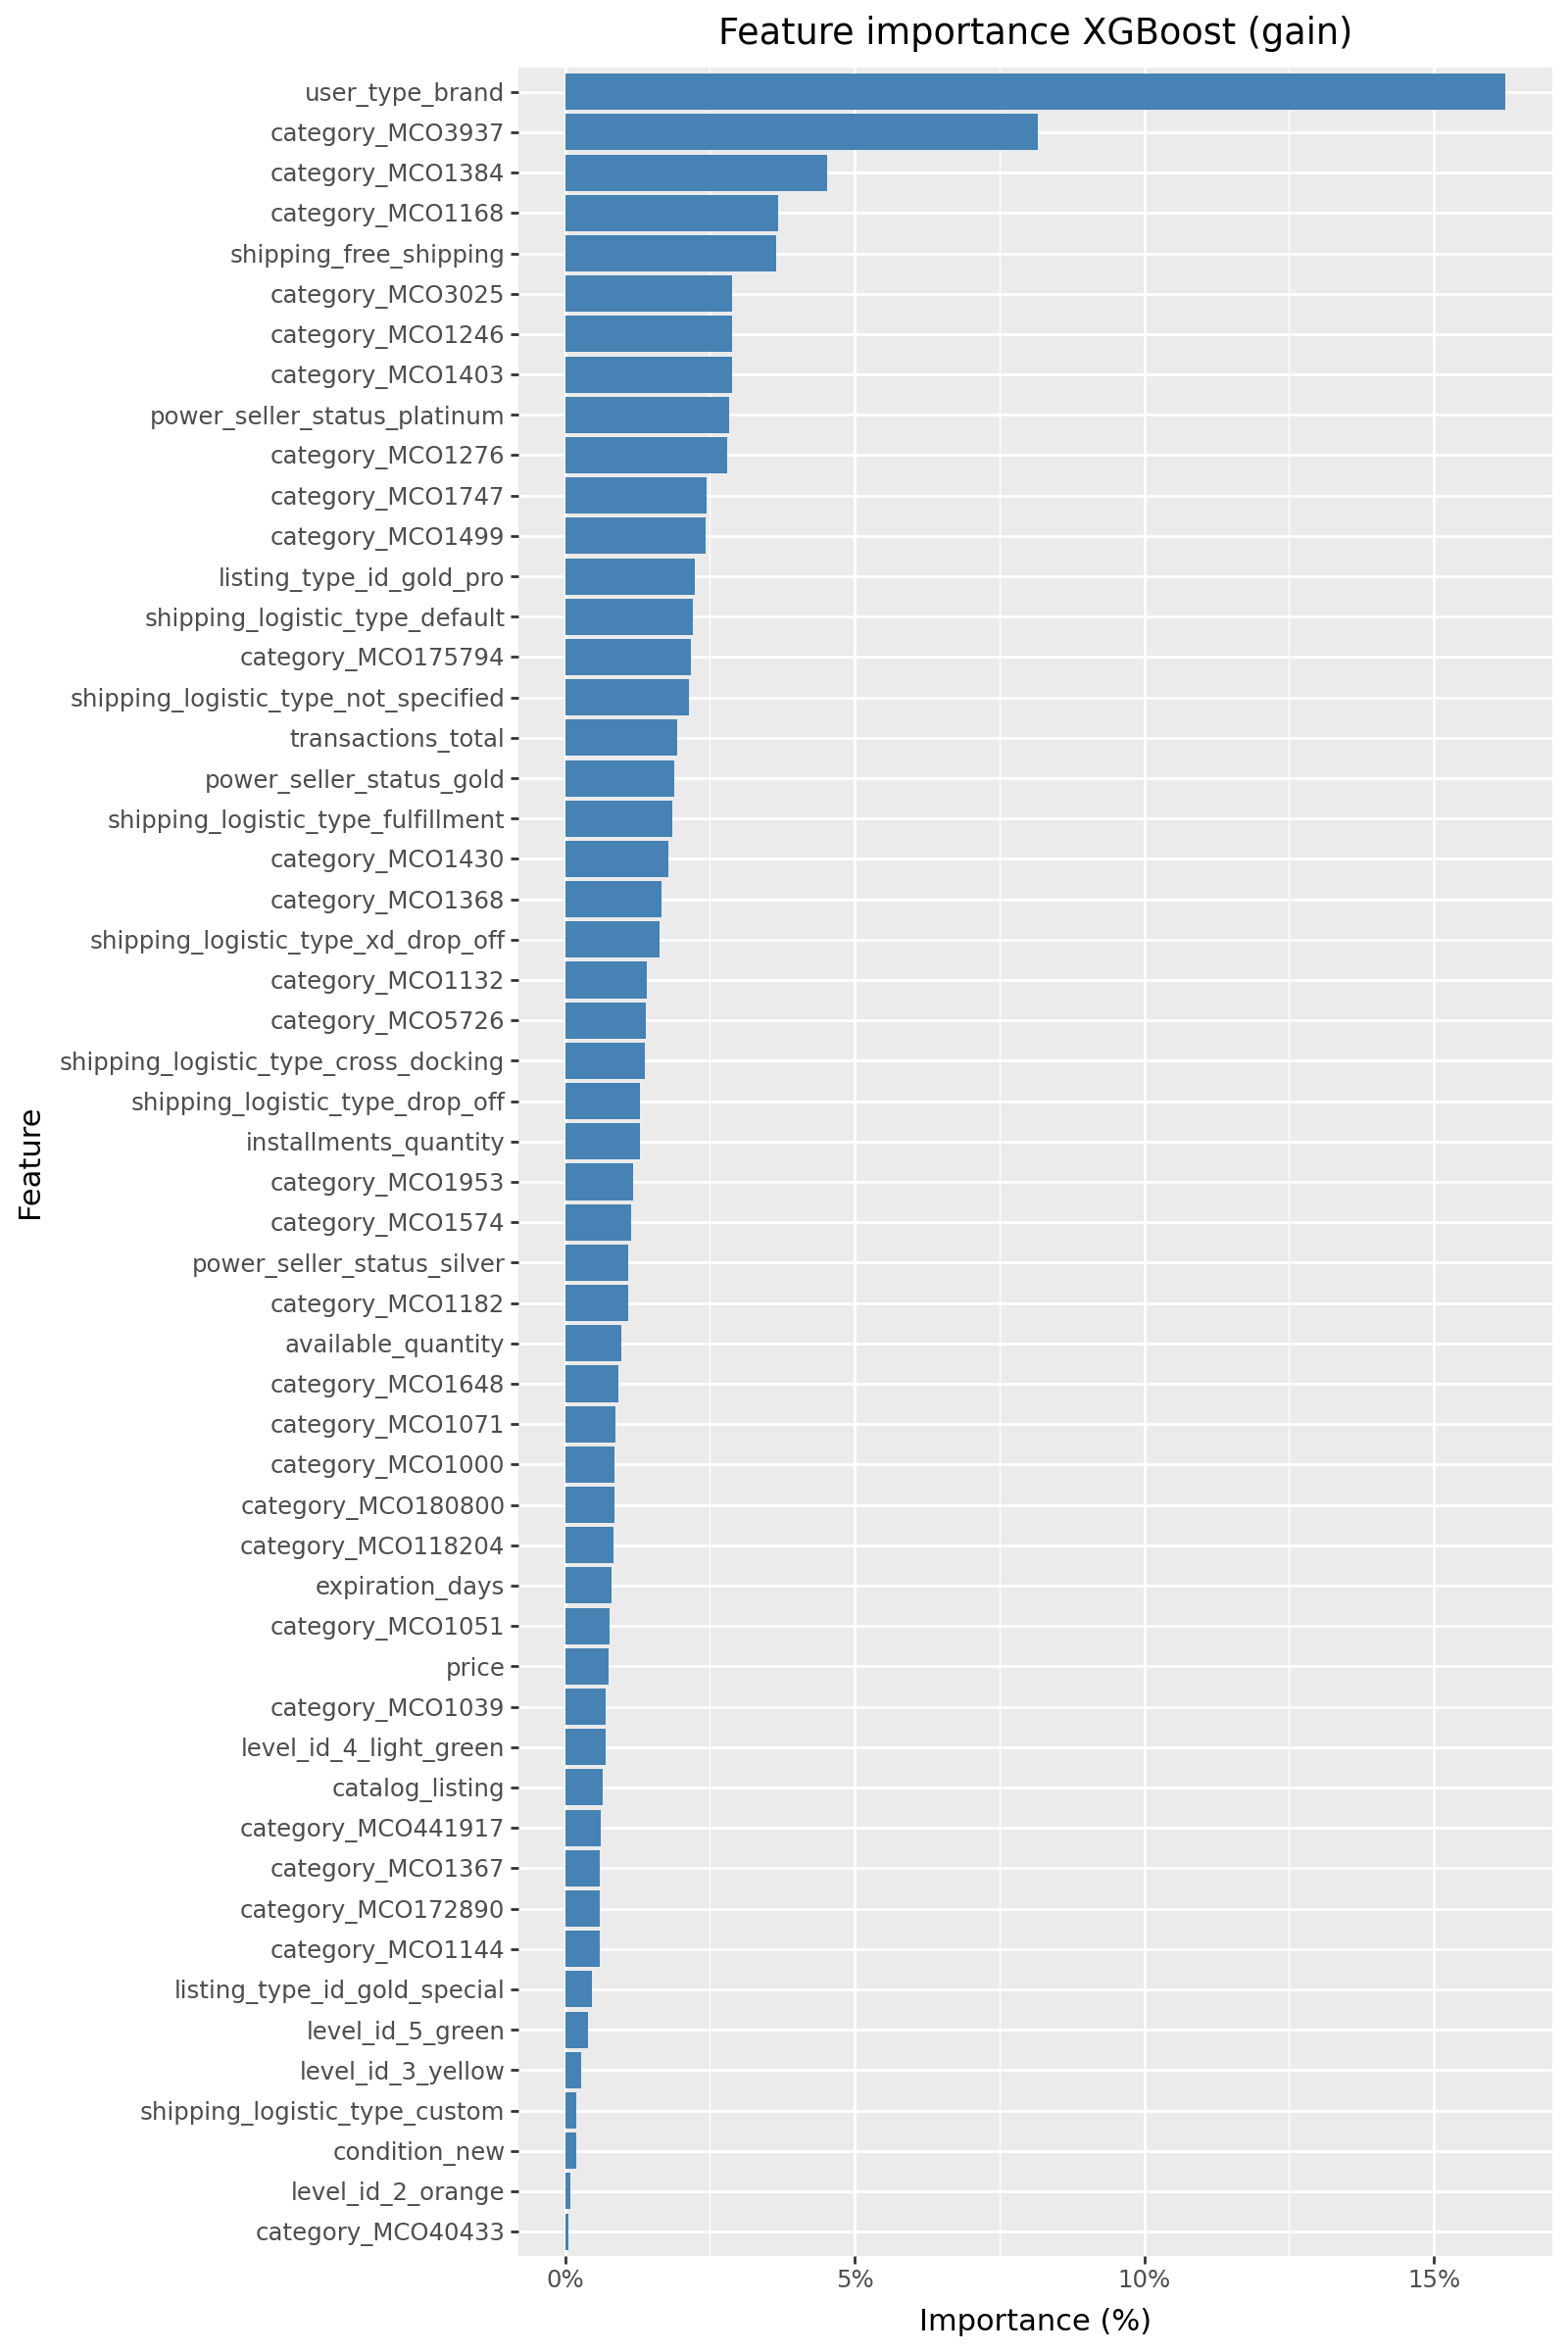

In [41]:
feature_order = feature_importance_scores_best["feature"].tolist()

(ggplot(feature_importance_scores_best, aes(x='feature', y='relative_importance')) +
 geom_bar(stat='identity', fill='steelblue') +
 theme(legend_position="none", figure_size=(8, 12)) + 
 labs(title="Feature importance XGBoost (gain)", x="Feature", y="Importance (%)") + 
 scale_y_continuous(labels = percent_format()) +
 scale_x_discrete(limits = feature_order[::-1]) +
 coord_flip()
)

### 2.4 Generación del modelo Lasso Regression

In [42]:
reg_lasso = Lasso()
reg_lasso = ModelGeneration(reg_lasso, (X_train, X_test, X_val, y_val,y_train, y_test))
reg_lasso.fit_model()
reg_lasso.model

Lasso()

#### 2.4.1 Métricas iniciales

In [43]:
reg_lasso.test_model(type="regression")

El R2 score es de 0.021090437080820257
El RMSE es de 0.13231324214177098
El MAPE es de 1.047152418459649


In [44]:
pred_results = pd.concat([y_test.reset_index(drop = True), 
                          pd.Series(reg_lasso.y_pred)], axis = 1).rename(columns = {"discount_rate" : "test",
                                                                                  0: "pred"})
pred_results.head()

,test,pred
0,0.140006,0.165509
1,0.270000,0.149947
2,0.087865,0.160542
3,0.150001,0.157631
4,0.455307,0.163474


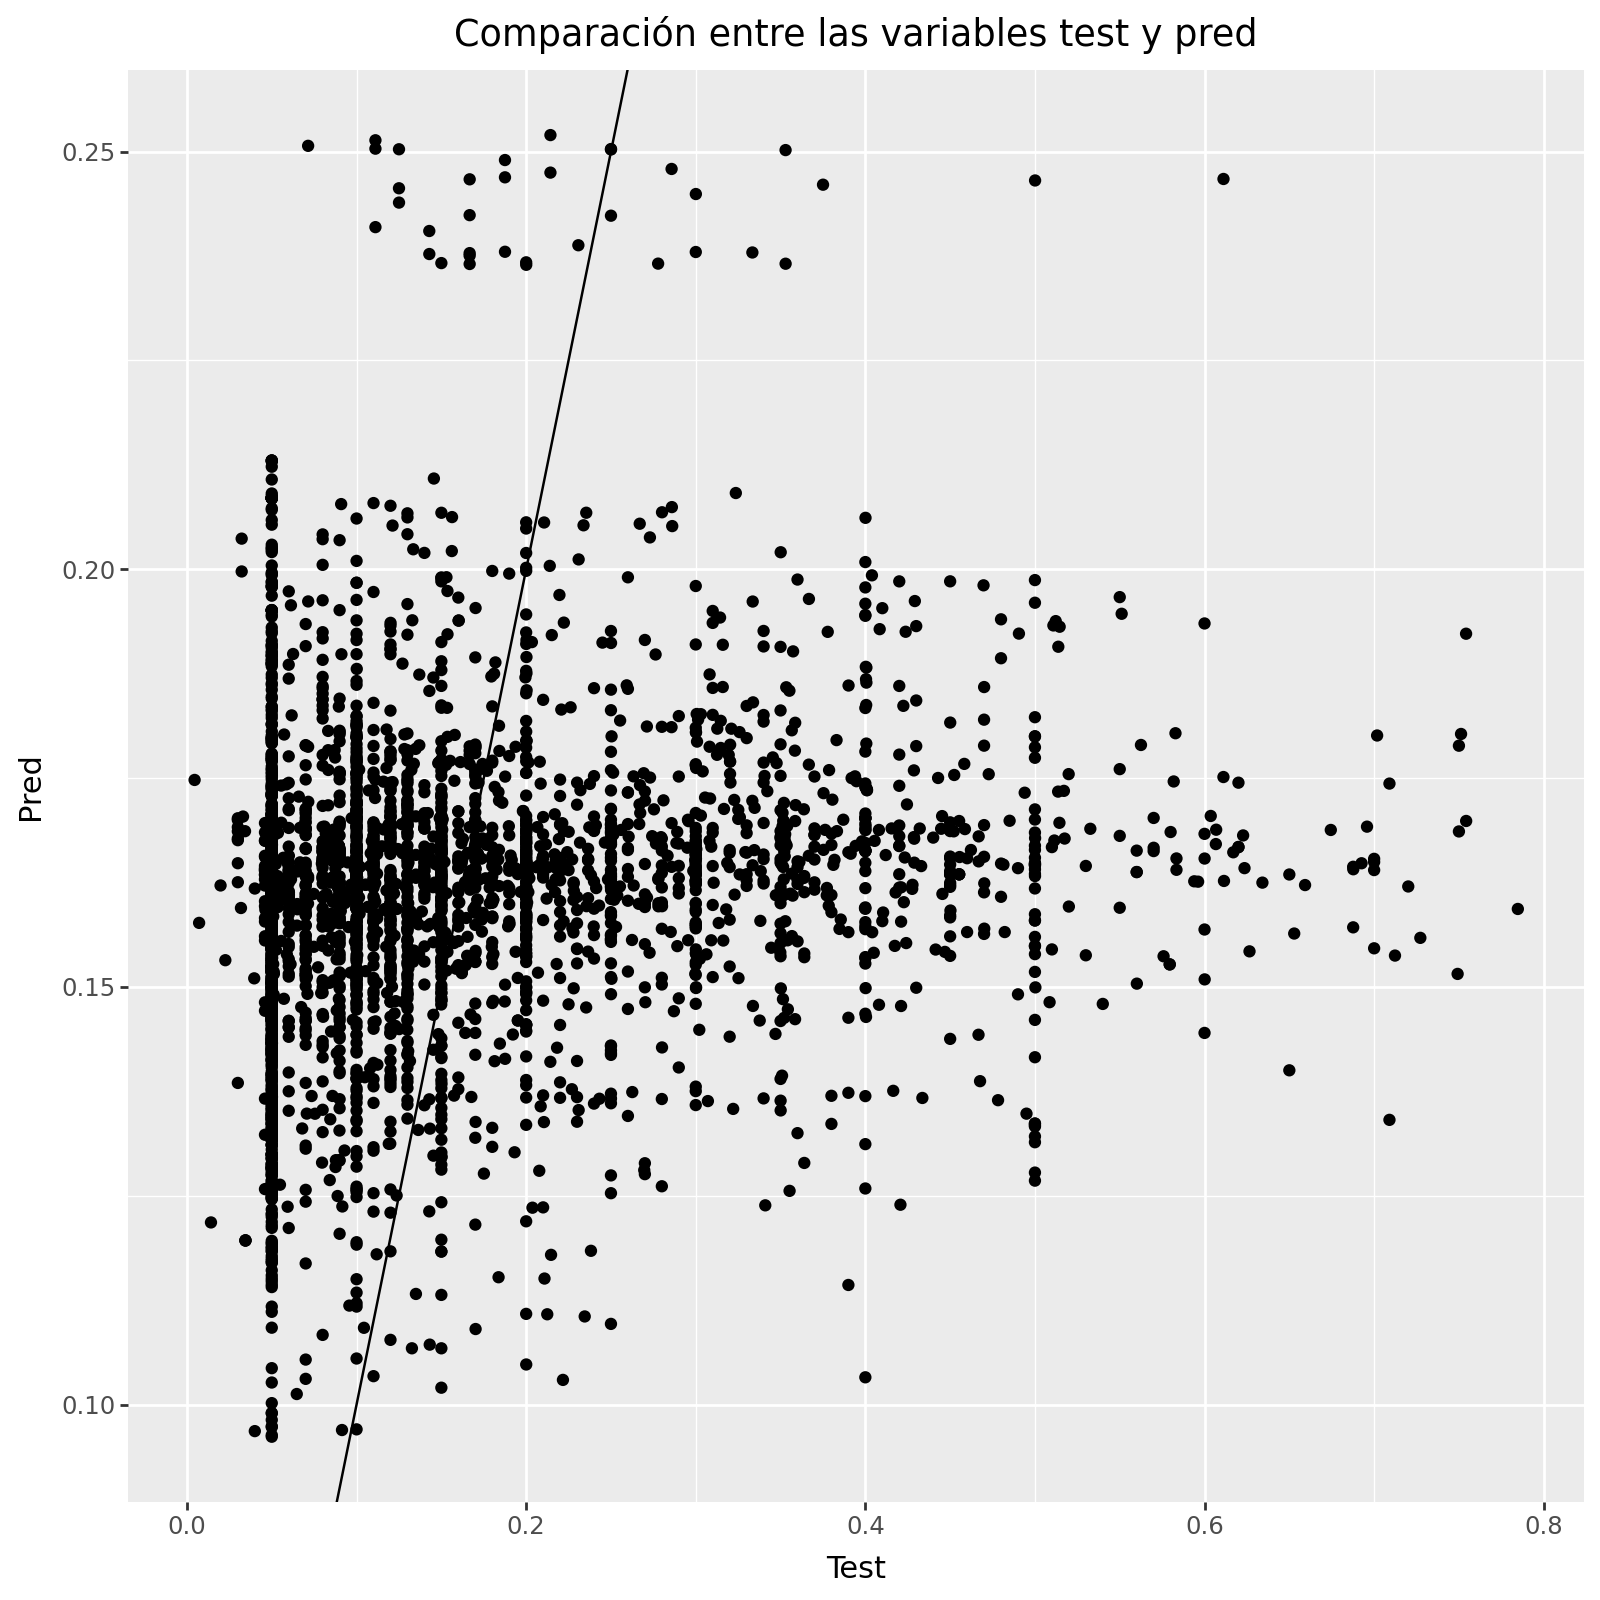

In [45]:
(ggplot(pred_results, aes(x='test', y='pred')) +
 geom_point() +
 geom_abline(
        intercept=0,  # set the y-intercept value
        slope=1,  # set the slope value
    ) +
 theme(figure_size=(8, 8)) + 
 labs(title="Comparación entre las variables test y pred", x="Test", y="Pred")
)

### 2.5 Optimización modelo XGBoost Regressor

#### 1.6.1 Grid search

In [46]:
param_grid = {
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.3, 0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7]
}

In [47]:
reg_xgb.fit_grid_search(param_grid, score_metric="neg_mean_squared_error")

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [48]:
print("Mejores hiperparametros: ", reg_xgb.best_params_)
print("Mejor score: ", reg_xgb.best_score_)

Mejores hiperparametros:  {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 8, 'subsample': 1}
Mejor score:  -0.008299961317866263


In [49]:
reg_xgb_tuned = ModelGeneration(XGBRegressor(), (X_train, X_test, X_val, y_val,y_train, y_test))
reg_xgb_tuned.fit_model(reg_xgb.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [50]:
reg_xgb_tuned.test_model(type = "regression")

El R2 score es de 0.543319952626263
El RMSE es de 0.09037286374519278
El MAPE es de 0.5869293154213332


In [51]:
feature_imp_best = reg_xgb_tuned.feature_importance_xgb()

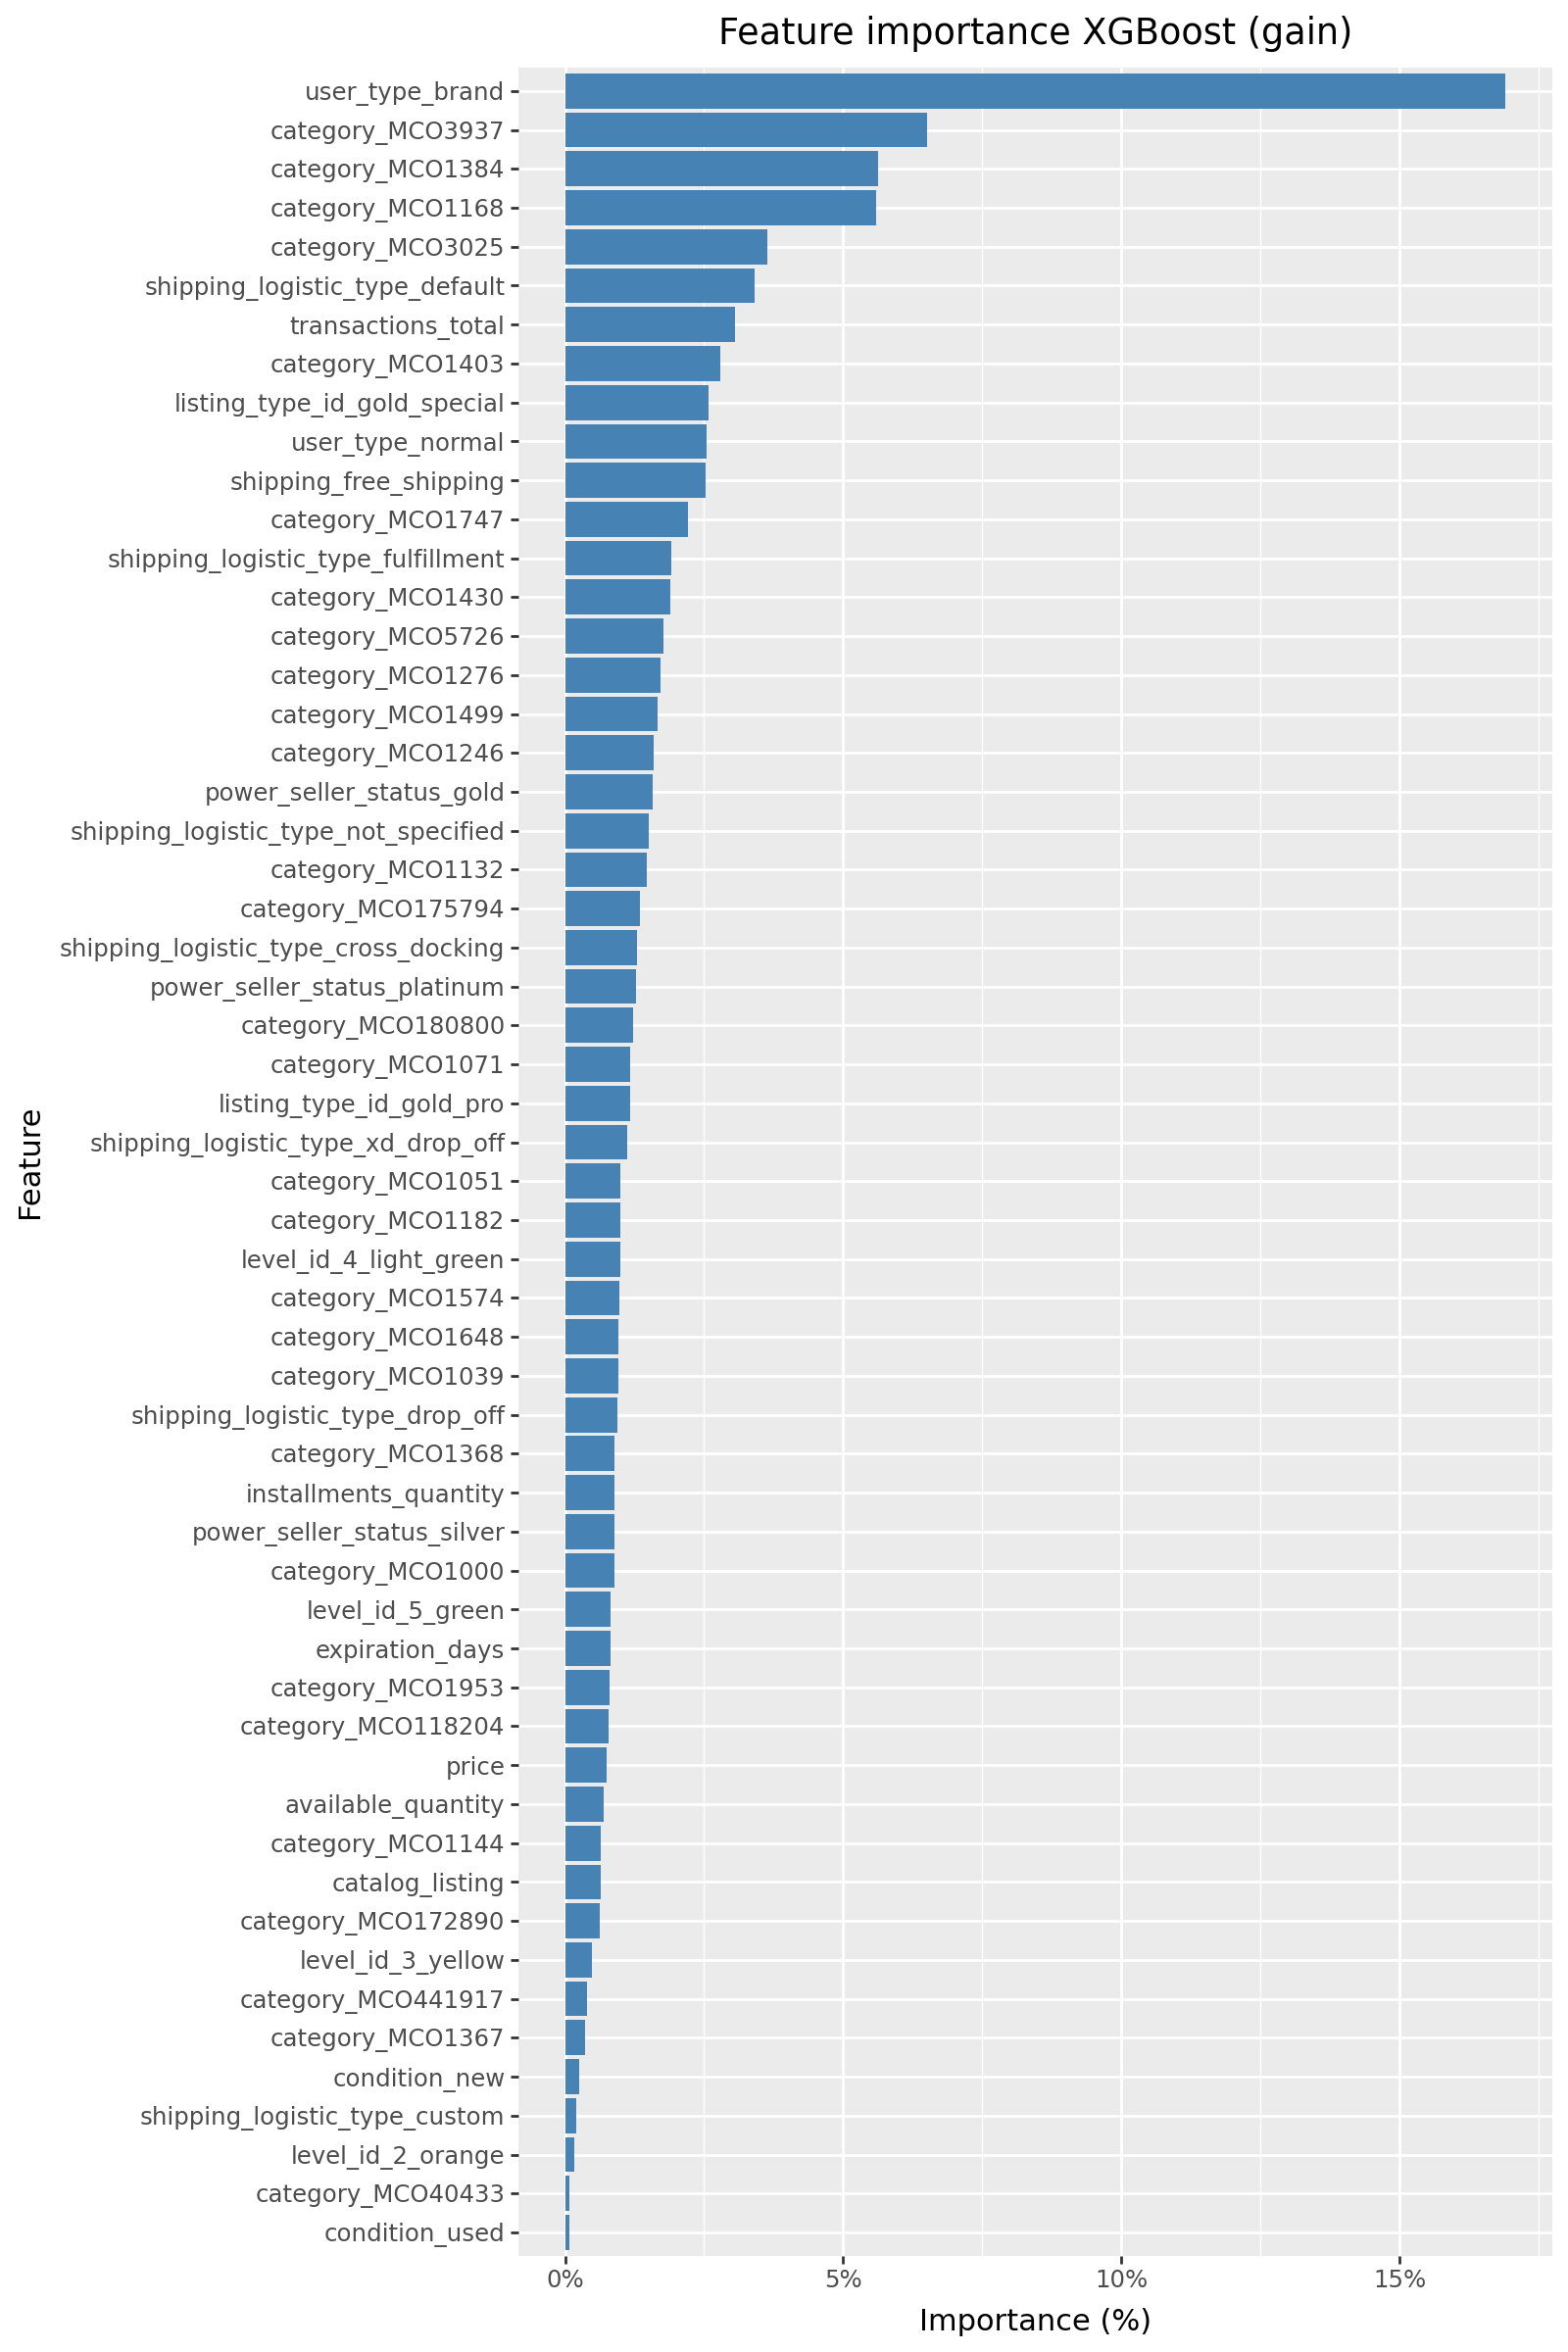

In [52]:
feature_order = feature_imp_best["feature"].tolist()

(ggplot(feature_imp_best, aes(x='feature', y='relative_importance')) +
 geom_bar(stat='identity', fill='steelblue') +
 theme(legend_position="none", figure_size=(8, 12)) + 
 labs(title="Feature importance XGBoost (gain)", x="Feature", y="Importance (%)") + 
 scale_y_continuous(labels = percent_format()) +
 scale_x_discrete(limits = feature_order[::-1]) +
 coord_flip()
)

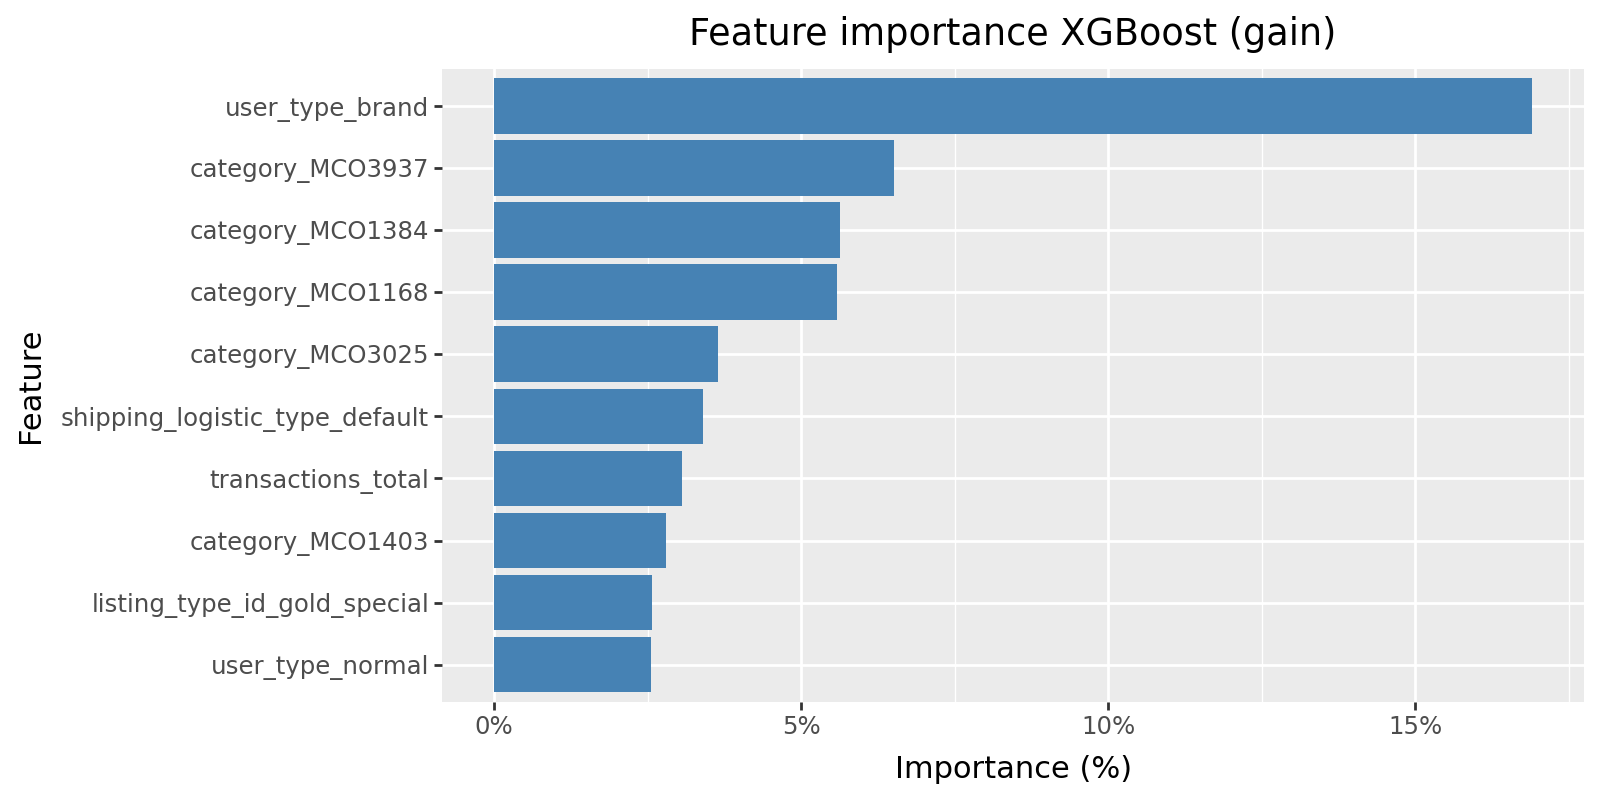

In [53]:
feature_order = feature_imp_best["feature"].head(10).tolist()

(ggplot(feature_imp_best.head(10), aes(x='feature', y='relative_importance')) +
 geom_bar(stat='identity', fill='steelblue') +
 theme(legend_position="none", figure_size=(8, 4)) + 
 labs(title="Feature importance XGBoost (gain)", x="Feature", y="Importance (%)") + 
 scale_y_continuous(labels = percent_format()) +
 scale_x_discrete(limits = feature_order[::-1]) +
 coord_flip()
)

In [54]:
reg_xgb_tuned.model.save_model("regression_discount_model.json")